<a href="https://colab.research.google.com/github/AnastasiaDvoynova/GameMarketAnalysis/blob/main/Game_Market_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Подготовка данных к анализу

Откроем файл с данными и изучим общую информацию.


In [361]:
import pandas as pd
import numpy

file_obj = pd.read_csv('https://raw.githubusercontent.com/AnastasiaDvoynova/GameMarketAnalysis/main/Data/games.csv')
file_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [362]:
new_columns = []
# создаем новый список для заголовков
for column in file_obj.columns:
    new_columns.append(column.lower())
print(new_columns)
# в цикле проходимся по каждому заголовку, меняем его регистр на нижний
# и записываем в новый список
file_obj.set_axis(new_columns, axis = 'columns', inplace = True)
# заменяем названия столбцов на новые

['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']


In [363]:
#%load_ext autoreload
#%autoreload 2
import sys

!{sys.executable} -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension

Requirement already up-to-date: pandas-profiling[notebook] in /usr/local/lib/python3.7/dist-packages (2.11.0)
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Посмотрим на отчёт по данным. 



1.   Отсутствующие значения занимают 12.1% от всего датасета.
2.   В данных нет дубликатов.
3.   В 269 записях отсутсуют данные о годе выпуска игры. Некоторые пропуски полностью случайны, эти данные можно восстановить как из названий некоторых игр, так и из источников интернета.
4.   В датасете большая представленноть игр жанра Action, Sports, Misc, Role-Playing, Shooter.
5.   В данных столбца critic_score и user_score отсутсвует 51,3% и 40,1% значений соотвественно. Достаточно большой процент отсутствующих значений, поэтому заполнение **nan** медианным или средним значением может вызвать неправильное отражение данных или их исказит. Можно предположить, что значения отсутвуют либо по случайности, либо потому, что игра была совсем непопулярна, поэтому рейтинга критиков и пользователей у нее нет. 
6.   В столбце user_score находится 2424 значения «tbd» или «to be determined», то есть будут определены. Эти значения неслучайные, так как либо значение калибруется или изменяется, либо данные о рейтинге появятся позже. Переведем эти значения в nan.

In [364]:
# импортируем библиотеку для создания отчета
import pandas_profiling
from pandas_profiling.utils.cache import cache_file
report = file_obj.profile_report(
    sort="None", html={"style": {"full_width": True}}, progress_bar=False)
report

In [365]:
file_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Можно заметить, что **year_of_realease** стоит перевести в тип **int** для наглядности, прежде заменив значения NaN на 0, чтобы не возникло ошибки. 
А **user_score** перевести в тип **float**, так как оценка чаще всего вещественное число.

In [366]:
NaN_error = 0 
file_obj['year_of_release'] = file_obj['year_of_release'].fillna(NaN_error).astype(int)
file_obj['user_score'] = pd.to_numeric(file_obj['user_score'], errors='coerce')
file_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец **global_sales**.

In [367]:
global_sales = file_obj['na_sales'] + file_obj['eu_sales'] + \
                  file_obj['jp_sales'] + file_obj['other_sales']
file_obj.insert(loc=8, column='global_sales', value=global_sales)

# 2. Проведение исследовательского анализа данных

In [368]:
# Импортируем необходимые библиотеки для визуализации
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import plotly

Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [369]:
year_game_count = file_obj[file_obj['year_of_release'] != 0].groupby(['year_of_release'])['name'].count()

In [370]:
import plotly.graph_objects as go
fig = go.Figure(
    data=[go.Bar(y = year_game_count, x = year_game_count.index)],
    layout_title_text="Количество релизов игр за весь период")
fig.show()

Вывод по графику:
1. Количество выпущенных игр на игровые приставки и ПК показывало постепенный рост с 1990 по 2008 год. 
2. С 2009 года видно сильное снижение. Это можно объяснить развитием рынка мобильных игр и игр для планшетов.
3. Совершенно незначительный рост релизов игр присутствует с 2013 по 2015 года. Согласно оценкам J’son & Partners, в 2013 году большая доля рынка приходилась на игровой ПК-рынок (почти 40%), и 37% занимал сегмент консолей, то в 2016 году самым крупным сегментом становится сегмент мобильных игр, генерируя выручку 36,9 млрд долларов, что соответствует 37% всего объема мирового рынка игр. То есть в 2016 году доходы в мобильном сегменте впервые превысили доходы от сегмента игр на персональных компьютерах. За 2013-2016 гг. для смартфонов показатель роста CAGR составил 28.4%, а для планшетов — 26.9%.
4. Таким образом, в 2017 году динамика выпуска игр на игровые приставки и ПК скорее всего так же будет показывать снижение.

Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [371]:
top_platforms = file_obj.groupby('platform')[['global_sales']].sum()\
  .sort_values('global_sales', ascending=False).head(5)

top_5_platform = top_platforms.reset_index().rename_axis(None, axis=1)
print(top_5_platform)

  platform  global_sales
0      PS2       1255.77
1     X360        971.42
2      PS3        939.65
3      Wii        907.51
4       DS        806.12


Text(0, 0.5, 'Сумма продаж')

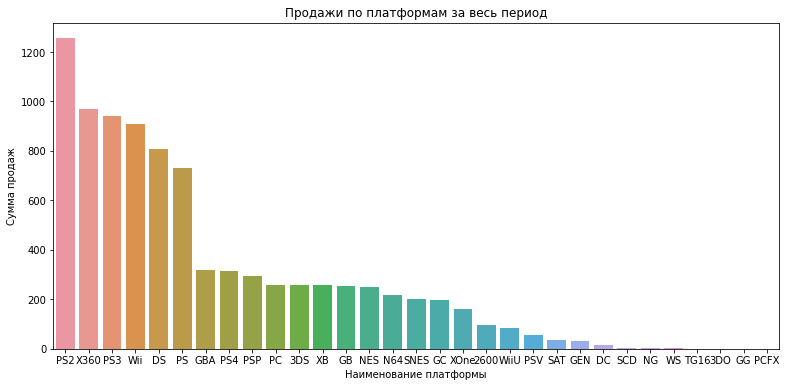

In [372]:
platform_sales = file_obj\
    .pivot_table(index='platform', values='global_sales', aggfunc='sum')\
    .sort_values(by='global_sales', ascending=False)

plt.figure(figsize=(13,6))
sns.barplot(x = platform_sales.index, y = platform_sales['global_sales'])
plt.title("Продажи по платформам за весь период")
plt.xlabel("Наименование платформы")
plt.ylabel("Сумма продаж")


Какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ.

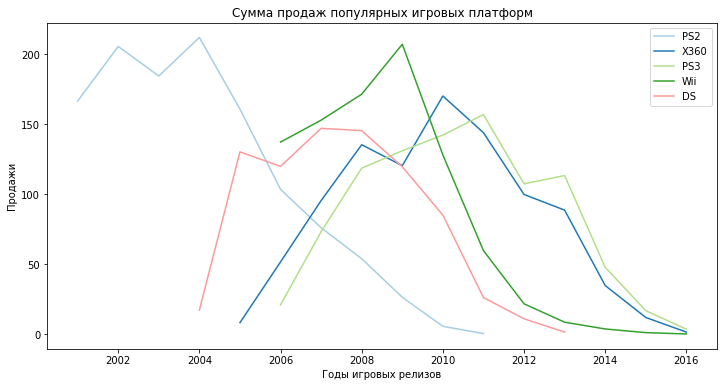

In [373]:
plt.figure(figsize=(12,6))
plt.title('Сумма продаж популярных игровых платформ')
plt.xlabel('Годы игровых релизов')
plt.ylabel('Продажи')
for i in list(top_5_platform['platform']):  
    platform_dynamisc = file_obj[(file_obj['platform'] == i) & (file_obj['year_of_release'] > 2000)]\
    .pivot_table(index='year_of_release', values='global_sales', aggfunc='sum')\
    .sort_values('year_of_release', ascending=False)
    
    sns.set_palette("Paired", 10)
    sns.lineplot(data=platform_dynamisc['global_sales'], label=i)
    plt.legend()


['PS2' 'DS' 'PS3' 'Wii' 'X360']


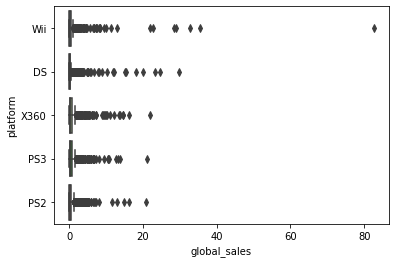

In [374]:

top_platforms = file_obj.platform.value_counts().sort_values(ascending = False).head(5).index.values
print(top_platforms)
sns.boxplot(y="platform", x="global_sales", data=file_obj[file_obj.platform.isin(top_platforms)], orient="h")

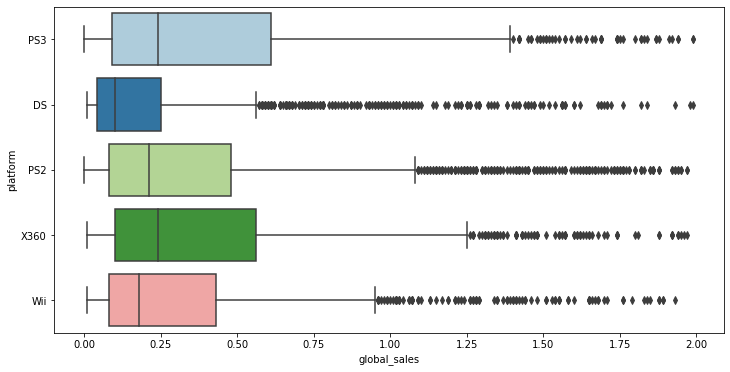

In [375]:
top_pplatforms = file_obj.platform.value_counts().sort_values(ascending = False).head(5).index.values
sv = file_obj[file_obj['global_sales'] < 2]
plt.figure(figsize=(12,6))
sns.boxplot(y="platform", x="global_sales", data=sv[sv.platform.isin(top_platforms)], orient="h")

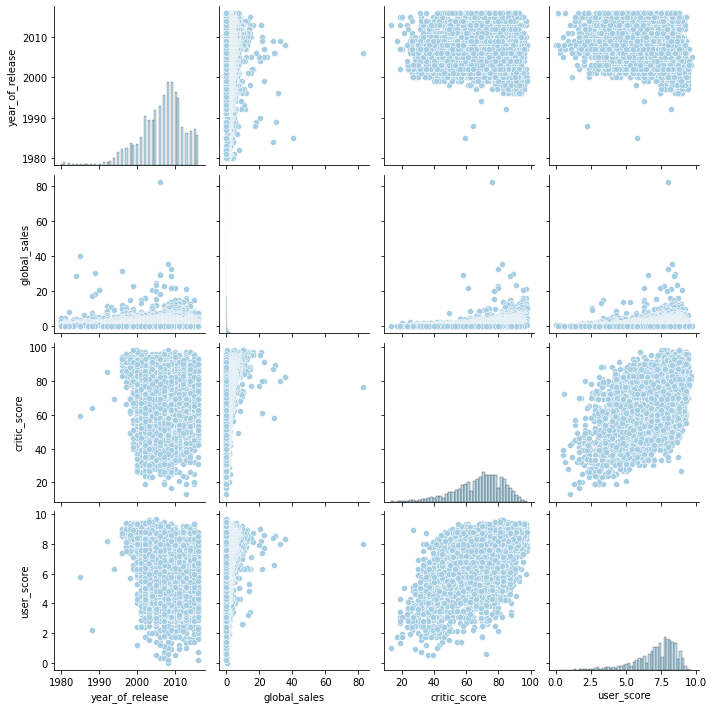

In [376]:
cols = ['year_of_release', 'genre', 'global_sales', 'critic_score', 'user_score', 'rating']
norm_year = file_obj[file_obj['year_of_release'] != 0]
sns_plot = sns.pairplot(norm_year[cols])


In [377]:
def correlation_platform_score(score, sales, platform):
  data = file_obj[file_obj['platform'] == platform]
  correlation = data[score].corr(data[sales])
  if 0.3 >= correlation >= 0.1:
    print('Корреляция между {} и {} на платформе {}'.format(score, sales, platform), ': Слабая')
  elif 0.5 >= correlation >= 0.3:
    print('Корреляция между {} и {} на платформе {}'.format(score, sales, platform), ': Умеренная')
  elif 0.7 >= correlation >= 0.5:
    print('Корреляция между {} и {} на платформе {}'.format(score, sales, platform), ': Высокая')
  elif 0.9 >= correlation >= 0.7:
    print('Корреляция между {} и {} на платформе {}'.format(score, sales, platform), ': Весьма высокая')
  elif 1 >= correlation >= 0.9:
    print('Корреляция между {} и {} на платформе {}'.format(score, sales, platform), ': Сильная')

for i in list(top_5_platform['platform']):
  correlation_platform_score('user_score', 'global_sales', str(i))
  correlation_platform_score('critic_score', 'global_sales', str(i))

Корреляция между user_score и global_sales на платформе PS2 : Слабая
Корреляция между critic_score и global_sales на платформе PS2 : Умеренная
Корреляция между user_score и global_sales на платформе X360 : Слабая
Корреляция между critic_score и global_sales на платформе X360 : Умеренная
Корреляция между user_score и global_sales на платформе PS3 : Слабая
Корреляция между critic_score и global_sales на платформе PS3 : Умеренная
Корреляция между user_score и global_sales на платформе Wii : Слабая
Корреляция между critic_score и global_sales на платформе Wii : Слабая
Корреляция между user_score и global_sales на платформе DS : Слабая
Корреляция между critic_score и global_sales на платформе DS : Слабая


Text(0, 0.5, 'Продажи')

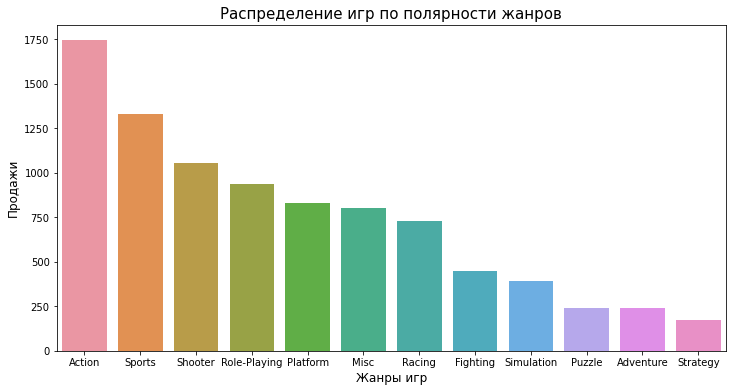

In [378]:
genre_distribution = file_obj\
  .pivot_table(index='genre', values='global_sales', aggfunc='sum')\
  .sort_values(by='global_sales', ascending=False)
genre_distribution = genre_distribution.reset_index().rename_axis(None, axis=1)
plt.figure(figsize=(12,6))
plt.title('Распределение игр по полярности жанров',fontsize=15)
sns.barplot(data=genre_distribution, x='genre', y='global_sales')
plt.xlabel('Жанры игр',fontsize=12)
plt.ylabel('Продажи',fontsize=12)

# Составление портрета пользователя каждого региона

In [379]:
# Напишем функцию, которая будет выбирать в сводную таблицу данные
# по необходимому объекту сравнения с определенного года
# и выводить график
def country_preferences(sales, country, year=1980):
  from_time = file_obj[file_obj['year_of_release'] >= year]
  for obj in ['platform', 'genre', 'rating']:
    country_preferences = from_time\
      .pivot_table(index= obj, values=sales, aggfunc='sum')\
      .sort_values(by=sales, ascending=False)\
      .head(5)
    country_preferences = country_preferences.reset_index().rename_axis(None, axis=1)

    plt.figure(figsize=(7,4))
    plt.title('Preferred {} in {} from {}'.format(obj, country, year),fontsize=15)
    sns.set_palette("flare")
    sns.barplot(data=country_preferences, x=obj, y=sales)
    plt.xlabel(str(obj),fontsize=12)
    plt.ylabel(str(sales),fontsize=12) 



## Посмотрим на предпочитаемые платформы, жанры и рейтинги игр **в Северной Америке** за весь период и с 2015 года. 


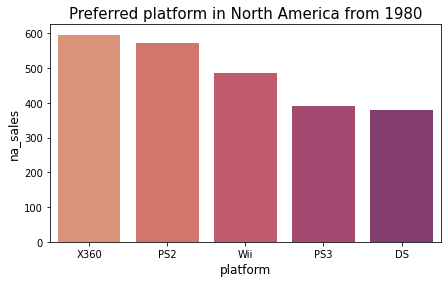

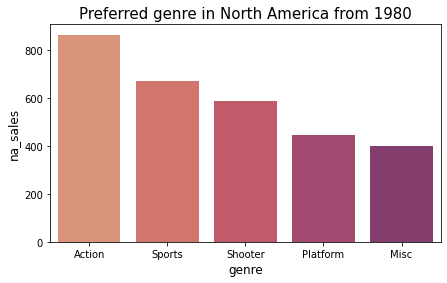

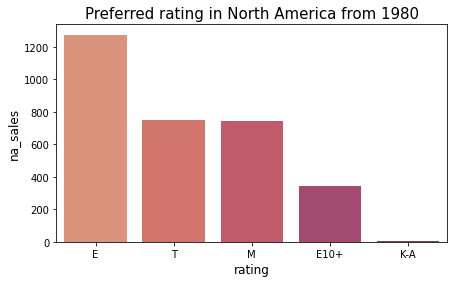

In [380]:
country_preferences('na_sales', 'North America') 

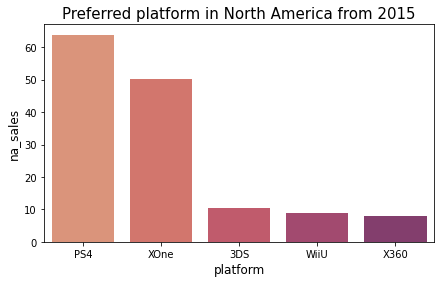

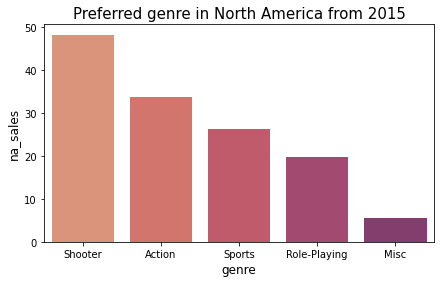

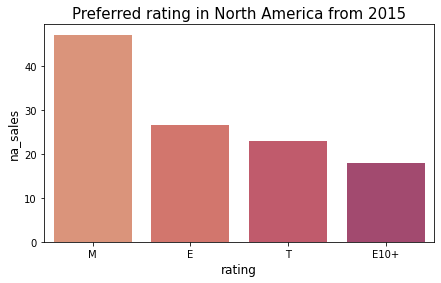

In [381]:
country_preferences('na_sales', 'North America', 2015) 

Вывод по графикам:

### За весь период:

***Самые популярные игровые платформы в Северной Америке***: XBOX, PS2, WII, PS3, DS.

***Топ-5 жанров***: Action, Sports, Shooter, Platform, Misc.

***Предпочитаемые рейтинги***: E (для всех) - наибольшее количество, T (для подростов) и M (для взрослых) примерно одинаковое количество.

### За период 2015-2016:
С 2015 по 2016 год интерес пользователей меняется:

***Топ игровых приставок выглядит таким образом***: PS4, Xone, DS3

***Топ жанров игр***: Shooter, Action, Sports.
За последний год американские пользователи больше предпочитали жанр Shooter жанру Action.

***Топ рейтингов игр***: M (для взрослых) - наибольшее количество, E (для всех) и T (для подростков)
За последний год американские пользователи больше предпочитали рейтинг игр М (для взрослых) рейтингу E (для всех).

## Посмотрим на предпочитаемые платформы, жанры и рейтинги игр **в Европейском Союзе** за весь период и с 2015 года.


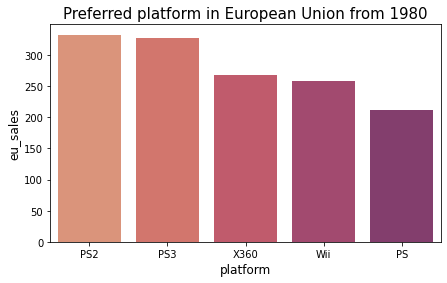

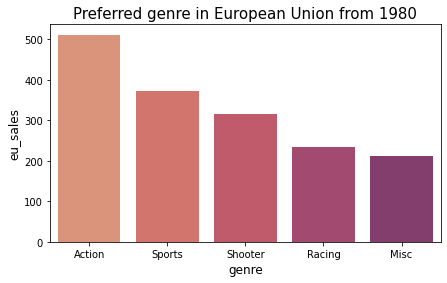

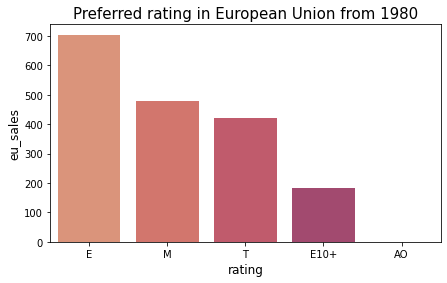

In [382]:
country_preferences('eu_sales', 'European Union') 

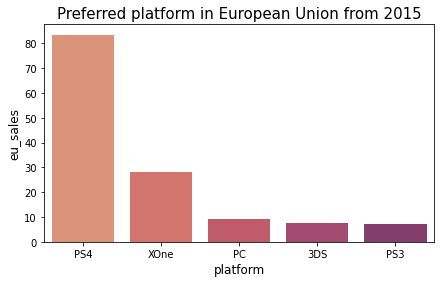

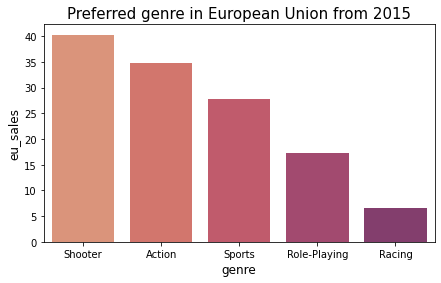

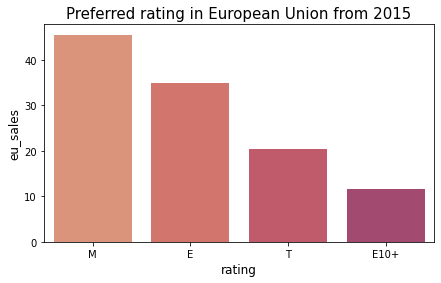

In [383]:
country_preferences('eu_sales', 'European Union', 2015) 

Вывод по графикам:

### За весь период:

***Самые популярные игровые платформы в Европейском Союзе***:  PS2, PS3, X360, WII, DS.

***Топ-5 жанров***: Action, Sports, Shooter, Racing, Misc.

***Предпочитаемые рейтинги***: E (для всех) - наибольшее количество, M (для взрослых) и чуть меньше T (для подростов).



### За период 2015-2016:
С 2015 по 2016 год предпочтение пользователей выглядит таким образом:

***Топ игровых приставок*** : PS4, Xone, PC

***Топ жанров игр***: Shooter, Sports, Action.
За последний год европейцы как и американские пользователи больше предпочитали жанр Shooter. Жанр Action опустился на 3 место.

***Топ рейтингов игр***: M (для взрослых) - наибольшее количество, E (для всех) и T (для подростков).
За последний год европейцы больше предпочитали рейтинг игр М (для взрослых) рейтингу E (для всех).

## Посмотрим на предпочитаемые платформы, жанры и рейтинги игр  **в Японии** за весь период и с 2015 года.


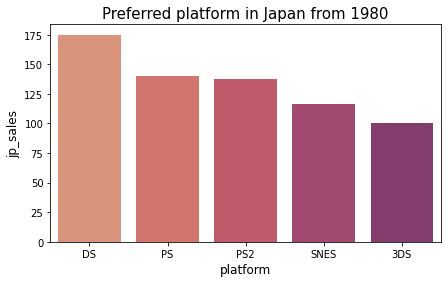

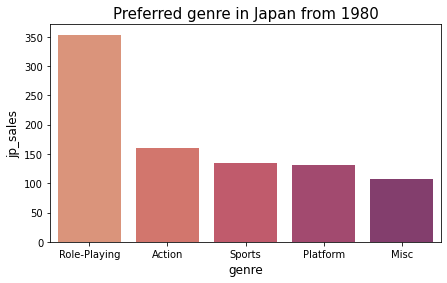

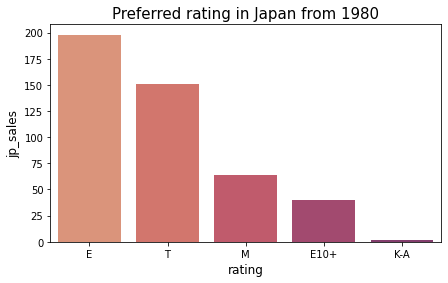

In [384]:
country_preferences('jp_sales', 'Japan') 

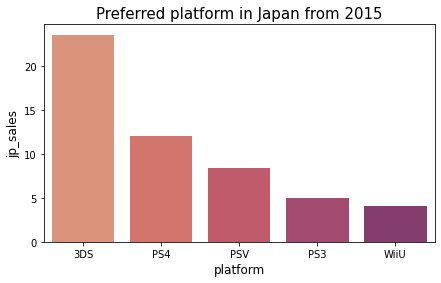

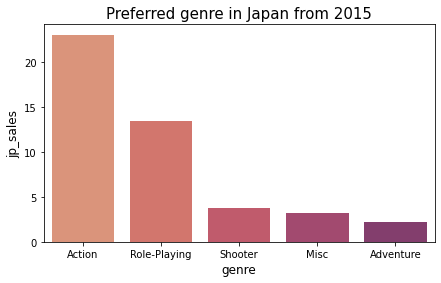

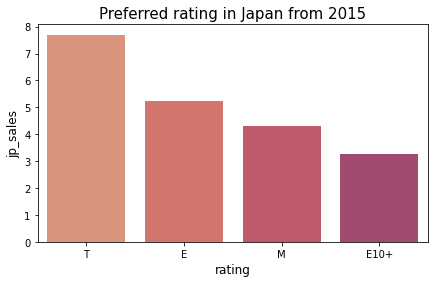

In [385]:
country_preferences('jp_sales', 'Japan', 2015) 

Вывод по графикам:

### За весь период:

***Самые популярные игровые платформы в Японии***:  DS, PS, PS2, SNES, 3DS.

***Топ-5 жанров***: Role-Playing, Action, Sports, Platform, Misc.

***Предпочитаемые рейтинги***: E (для всех) - наибольшее количество, T (для подростов),  M (для взрослых).



### За период 2015-2016:
С 2015 по 2016 год предпочтение пользователей выглядит таким образом:

***Топ игровых приставок*** : 3DS, PS4, PSV.

***Топ жанров игр***: Action, Role-playing, Adventure
За последние годы японские пользователи больше предпочитали жанр Action. Жанр Role-playing опустился на 2 место.

***Топ рейтингов игр***: T (для подростков) - наибольшее количество, E (для всех) и M (для взрослых).
За последние годы японцы больше предпочитали рейтинг игр T (для подростков) рейтингу E (для всех).